In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import gensim
import cython
import scipy

unable to import 'smart_open.gcs', disabling that module


In [ ]:

# Randomly split edges according to 80/20 holdout wihout replacement, reference: OptimalLinkPrediction
# Repeated over 5 times under different seeds so create a function for this
#def train_val_split(oriG, seed=None, mode='scorpus'):

    # Reference: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/
    # Split according to vidhya, holdout with no isolated nodes
    #if mode == 'vidhya':

    # Reference: https://github.com/Aghasemian/OptimalLinkPrediction/blob/master/Code/OLP.py
    # Split according to olp paper, holdout with sampling procedure
    #if mode == 'olp':

    # Reference: https://www.researchgate.net/publication/330927932_Link_Prediction_in_Co-authorship_Networks_Using_Scopus_Data_5th_International_Conference_SIMBig_2018_Lima_Peru_September_3-5_2018_Proceedings
    # Split according to scorpus paper, pure holdout without pruning since number of nodes are less
    # Ignore the common vertex step, that is just another test set for them to use
    # Randomly drop links until 80% remaining, label rest as '0',
    # then drop '0's until 50/50 to handle class imbalance
    # Use all dropped '1's and equal amount of dropped '0's for validation
    #if mode == 'scorpus':


    #return trainE, valE

# Create train-val for '1's
#valE = link_df.sample(frac=0.2, random_state=123)
#trainE = link_df.drop(index=valE.index.values)

# Create train-val for '0's
#val_unconnected = unconnected_df.sample(n=valE.shape[0], random_state=123)
#unused_unconnected = unconnected_df.drop(index=val_unconnected.index.values)

# Concatenate together
#valE = pd.concat([valE, val_unconnected])
#trainE = pd.concat([trainE, unused_unconnected])
#trainG= nx.from_pandas_edgelist(trainE,'source', 'sink', create_using=nx.Graph())

In [143]:
from output_edgelist import output_edgelist

frac = 5 # 1,5,10 : 30 mins, 2 hr, 5 hr
seed = 123

oriG = nx.read_graphml('originalG.graphml')
trainE = output_edgelist(oriG, frac=frac, seed=seed)

In [5]:
from node2vec import Node2Vec

# Generate walks
#node2vec = Node2Vec(trainG, dimensions=100, walk_length=16, num_walks=50)
node2vec = Node2Vec(oriG, dimensions=100, walk_length=16, num_walks=50)

# Train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

# Save embeddings for later use
n2w_model.wv.save_word2vec_format('n2v_embed')

# Save model for later use
n2w_model.save('n2v_model')

Generating walks (CPU: 1):   4%|██▏                                                     | 2/50 [00:02<00:53,  1.12s/it]

KeyboardInterrupt: 

In [4]:
from gensim.models import Word2Vec

# Load model
n2w_model = Word2Vec.load('n2v_model')

In [153]:
from generate_features import generate_features

# Note: changes needed if underlying graph object is changed
#feature_obj_path = None
feature_obj_path = './feature_obj/'

#SVD_path = None
SVD_path = './SVD/'

feature_df = generate_features(trainE, oriG, n2w_model,
                               SVD_path=SVD_path,
                               feature_obj_path=feature_obj_path)

#feature_obj_path = './feature_obj/'
feature_df_path = 'trainE_full_features_imbalanced_{}_{}.csv'.format(frac, seed)
feature_df.to_csv(feature_df_path)


Computing feature objects, takes quite awhile...
Computing eigen-centrality...
Saving dictionaries...
Loading SVD and approx SVD...


  0%|                                                                             | 3/161610 [00:00<2:05:41, 21.43it/s]

Processing edgelist


100%|████████████████████████████████████████████████████████████████████████| 161610/161610 [2:21:41<00:00, 19.01it/s]


In [155]:
# Load train edges
#feature_df = pd.read_csv('trainE_full_features_imbalanced_{}_{}.csv'.format(frac, seed), index_col=0)

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

seed=32

# 80/20 split
xtrain, xtest, ytrain, ytest = train_test_split(feature_df, trainE['link'],
                                                test_size = 0.2,
                                                random_state = seed,
                                                shuffle=True,
                                                stratify=trainE['link'])
# 60/20/20 split

xtrain, xval, ytrain, yval =  train_test_split(xtrain, ytrain,
                                                test_size = 0.25,
                                                random_state = seed,
                                                shuffle=True,
                                                stratify=ytrain)

# Select best features, but no big changes test performance
lr = SelectFromModel(estimator=LogisticRegression(class_weight='balanced'))

lr.fit(xtrain, ytrain)
xtt = lr.transform(xtrain)

logR = LogisticRegression(class_weight='balanced')
logR.fit(xtt , ytrain)
predictions = logR.predict_proba(lr.transform(xtest))
roc_auc_score(ytest, predictions[:,1])


"\nxtrain, xval, ytrain, yval =  train_test_split(xtrain, ytrain, \n                                                test_size = 0.25, \n                                                random_state = seed,\n                                                shuffle=True,\n                                                stratify=ytrain)\n\n# Select best features, but no big changes test performance\nlr = SelectFromModel(estimator=LogisticRegression(class_weight='balanced')) \n\nlr.fit(xtrain, ytrain)\nxtt = lr.transform(xtrain)\n\nlogR = LogisticRegression(class_weight='balanced')\nlogR.fit(xtt , ytrain)\npredictions = logR.predict_proba(lr.transform(xtest))\nroc_auc_score(ytest, predictions[:,1])\n"

In [65]:
# Get most important columns for LR
sp= list(lr.get_support())
indexes=[i for i, x in enumerate(sp) if x]
for i in indexes:
    print(feature_df.columns[i])

n2v_6
n2v_8
n2v_16
n2v_17
n2v_38
n2v_96
src_local_clus
sink_local_clus
common_neigh
jaccard
resource_alloc_ind
adamic_adar_ind


In [158]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
val_data = lgbm.Dataset(xval, yval)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5, # Feature subsampling
    'bagging_fraction': 0.5,
    'bagging_freq': 200,
    'lambda_l1':2,
    'lambda_l2':4,
    'num_threads' : 2,
    'seed' : 123
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=val_data,
                   num_boost_round=10000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.982902
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.984301
[3]	valid_0's auc: 0.987081
[4]	valid_0's auc: 0.9876
[5]	valid_0's auc: 0.988163
[6]	valid_0's auc: 0.9884
[7]	valid_0's auc: 0.989022
[8]	valid_0's auc: 0.989403
[9]	valid_0's auc: 0.989607
[10]	valid_0's auc: 0.989865
[11]	valid_0's auc: 0.990034
[12]	valid_0's auc: 0.990158
[13]	valid_0's auc: 0.990197
[14]	valid_0's auc: 0.990206
[15]	valid_0's auc: 0.990517
[16]	valid_0's auc: 0.990662
[17]	valid_0's auc: 0.990815
[18]	valid_0's auc: 0.990948
[19]	valid_0's auc: 0.991062
[20]	valid_0's auc: 0.991244
[21]	valid_0's auc: 0.991439
[22]	valid_0's auc: 0.991536
[23]	valid_0's auc: 0.991699
[24]	valid_0's auc: 0.991824
[25]	valid_0's auc: 0.99198
[26]	valid_0's auc: 0.992076
[27]	valid_0's auc: 0.99213
[28]	valid_0's auc: 0.992196
[29]	valid_0's auc: 0.9923
[30]	valid_0's auc: 0.992426
[31]	valid_0's auc: 0.992545
[32]	valid_0's auc: 0.992666
[33]	valid_0's auc: 0.99285


In [159]:
"""
predictions = model.predict(xtest)
roc_auc_score(ytest, predictions)
"""
create_public_prediction(n2w_model, oriG, model, feature_obj_path, SVD_path, 'lgbm')
# AUC(5*)= 0.92820, AUC(10*) = 0.93041

Loading feature objects...
Loading SVD and approx SVD...


  0%|                                                                                 | 3/2000 [00:00<01:36, 20.70it/s]

Processing edgelist


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.67it/s]


./test_predictions/prediction_lgbm_22-Apr-2020--11-07-26.csv created.


In [127]:
from datetime import datetime

def create_public_prediction(n2w_model, oriG, model, feature_obj_path, SVD_path, classifier='lr'):

    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y--%H-%M-%S")

    kaggle = generate_features(pd.read_csv('test-public.csv', index_col='Id', dtype={'Source':'string', 'Sink':'string'}),
                               oriG, n2w_model,
                               SVD_path=SVD_path,
                               feature_obj_path=feature_obj_path)

    if classifier == 'lr' or classifier == 'rf':
        kaggle_pred=pd.DataFrame(model.predict_proba(kaggle)[:,1]) # probabilities according to [0,1], use (modelname).classes_
    if classifier == 'lgbm':
        kaggle_pred=pd.DataFrame(model.predict(kaggle)) # probabilities according to [0,1], use (modelname).classes_

    kaggle_pred.columns = ['Predicted']
    kaggle_pred.index += 1
    filename = './test_predictions/prediction_{}_{}.csv'.format(classifier, timestampStr)
    kaggle_pred.to_csv(filename, index=True, index_label='Id')
    print(filename,'created.')

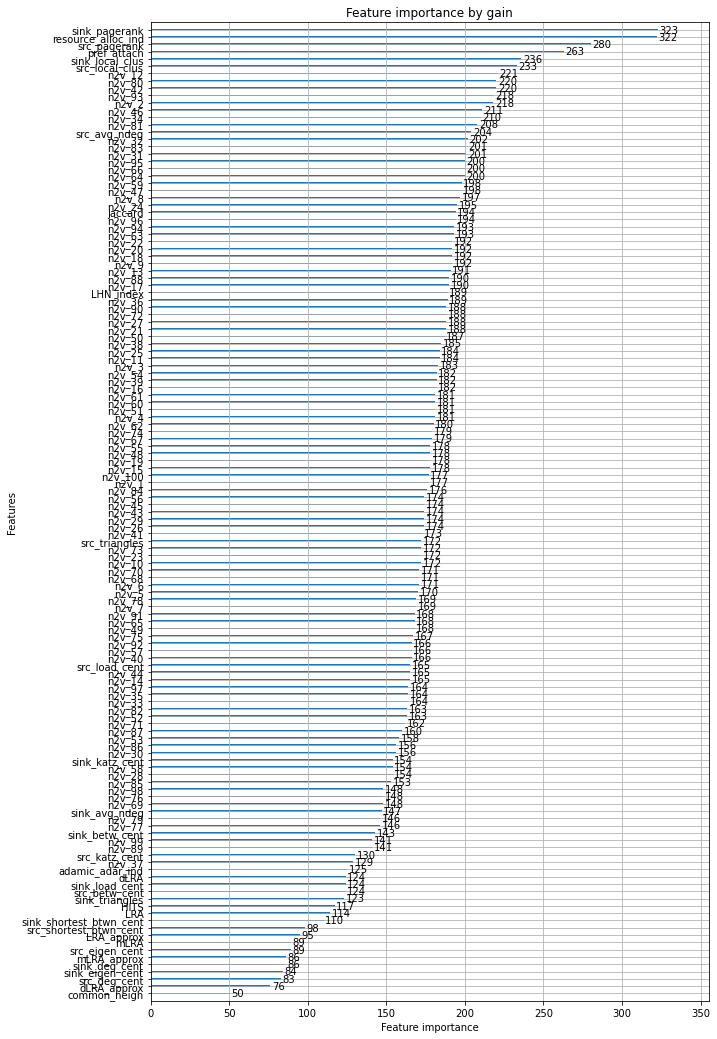

In [186]:
lgbm.plot_importance(model, title='Feature importance by gain', figsize=(10,18))
fi={}
fi['feature'] = list(feature_df.columns)
fi['importance'] = list(model.feature_importance())
imp_features = pd.DataFrame(fi).sort_values(by=['importance'], ascending=False)

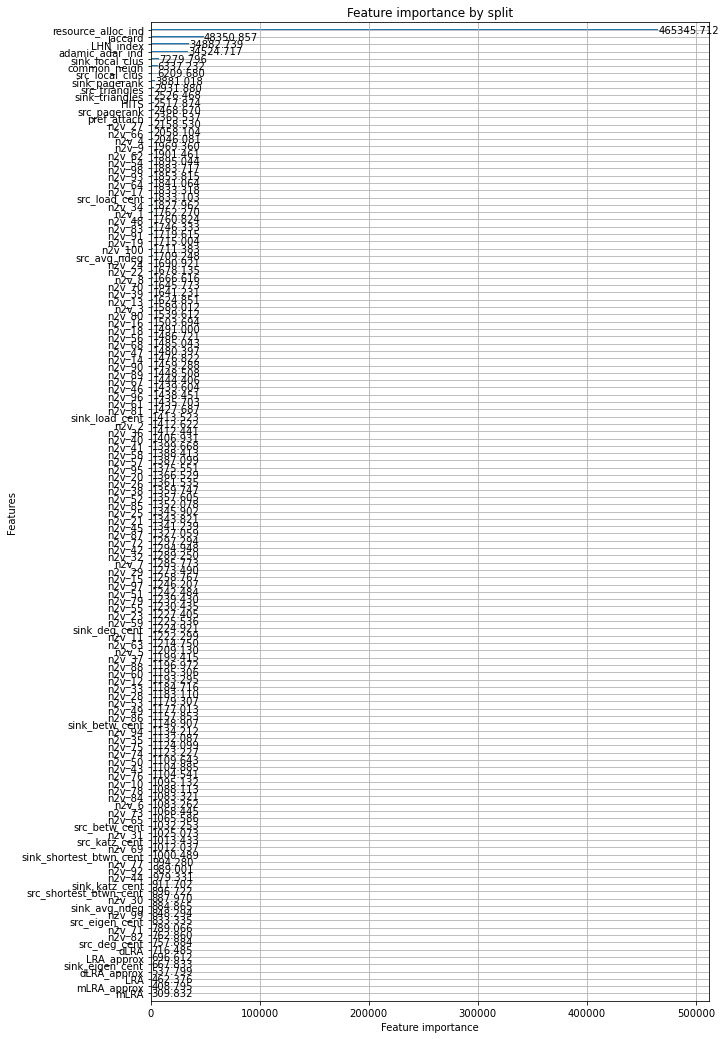

In [187]:
lgbm.plot_importance(model, title='Feature importance by split', importance_type='gain', figsize=(10,18))

In [172]:
len(feature_df.columns)

133

In [189]:
import shap
shap.TreeExplainer(model).shap_values(xtrain)
shap.summary_plot(shap_values, xtrain)

ModuleNotFoundError: No module named 'shap'

In [176]:
# Top 50 features
imp_features[:50]

,feature,importance
117,sink_pagerank,323
125,resource_alloc_ind,322
116,src_pagerank,280
122,pref_attach,263
101,sink_local_clus,236
100,src_local_clus,233
11,n2v_12,221
79,n2v_80,220
41,n2v_42,220
92,n2v_93,218


In [177]:
# Bottom 50 features
imp_features[-50:]

,feature,importance
74,n2v_75,167
56,n2v_57,166
91,n2v_92,166
39,n2v_40,166
43,n2v_44,165
118,src_load_cent,165
13,n2v_14,165
96,n2v_97,164
32,n2v_33,164
34,n2v_35,164


In [123]:
from sklearn.ensemble import RandomForestClassifier as RFC

rf= RFC(class_weight='balanced', random_state=seed)

rf.fit(xtrain, ytrain)
predictions=rf.predict_proba(xval)
print(roc_auc_score(yval, predictions[:,1]))

create_public_prediction(n2w_model, oriG, rf, feature_obj_path, SVD_path, 'rf')
# AUC: 0.92288

0.9933927471993318

In [160]:
from bayes_opt import BayesianOptimization

# Adapted from: https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm
def bayes_parameter_opt_lgb(train_data, init_round=15, opt_round=25, n_folds=5, random_seed=123, n_estimators=10000, learning_rate=0.05, output_process=False):

    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y--%H-%M-%S")

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary',
                  'num_iterations': n_estimators,
                  'learning_rate':learning_rate,
                  'early_stopping_round':20,
                  'metric':'auc',
                  'is_unbalance':True}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])

    # range
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 45),
                                            'feature_fraction': (0.2, 0.8),
                                            'bagging_fraction': (0.2, 0.8),
                                            'max_depth': (5, 9),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=123)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result_{}.csv".format(timestampStr))

    # return Optimiser object
    return lgbBO

optimiser = bayes_parameter_opt_lgb(train_data, init_round=5, opt_round=15, n_folds=3, n_estimators=2000, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995736 + 3.52459e-05
[400]	cv_agg's auc: 0.996714 + 3.88111e-05
[600]	cv_agg's auc: 0.997139 + 5.08076e-05
[800]	cv_agg's auc: 0.997395 + 4.07797e-05
[1000]	cv_agg's auc: 0.997569 + 5.4873e-05
[1200]	cv_agg's auc: 0.997689 + 6.03669e-05
[1400]	cv_agg's auc: 0.997782 + 7.04216e-05
[1600]	cv_agg's auc: 0.99785 + 7.14665e-05
[1800]	cv_agg's auc: 0.997897 + 7.1882e-05
[2000]	cv_agg's auc: 0.997941 + 7.34162e-05
|  1        |  0.9979   |  0.6179   |  0.3717   |  1.134    |  1.654    |  7.878    |  24.04    |  0.0981   |  37.12    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995376 + 6.15766e-05
[400]	cv_agg's auc: 0.996312 + 3.30506e-05
[600]	cv_agg's auc: 0.996724 + 1.98296e-05
[800]	cv_agg's auc: 0.996989 + 1.65468e-05
[1000]	cv_agg's auc: 0.997156 + 1.86846e-05
[1200]	cv_agg's auc: 0.997274 + 1.92594e-05
[1400]	cv_agg's auc: 0.997358 + 2.31965e-05
[1600]	cv_agg's auc: 0.997427 + 3.14026e-05
[1800]	cv_agg's auc: 0.997481 + 3.34883e-05
[2000]	cv_agg's auc: 0.99753 + 3.52207e-05
|  2        |  0.9975   |  0.4886   |  0.4353   |  1.716    |  2.187    |  6.754    |  7.686    |  0.04041  |  38.45    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.99571 + 6.55642e-05
[400]	cv_agg's auc: 0.996757 + 7.31887e-05
[600]	cv_agg's auc: 0.997194 + 8.17849e-05
[800]	cv_agg's auc: 0.99744 + 8.04191e-05
[1000]	cv_agg's auc: 0.997594 + 9.18158e-05
[1200]	cv_agg's auc: 0.997714 + 8.69223e-05
[1400]	cv_agg's auc: 0.997795 + 8.96081e-05
[1600]	cv_agg's auc: 0.99786 + 8.59498e-05
[1800]	cv_agg's auc: 0.997902 + 8.04631e-05
[2000]	cv_agg's auc: 0.997942 + 8.31915e-05
|  3        |  0.9979   |  0.3095   |  0.3053   |  2.658    |  1.595    |  7.538    |  43.22    |  0.07272  |  35.28    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995197 + 6.58853e-05
[400]	cv_agg's auc: 0.996371 + 6.49171e-05
[600]	cv_agg's auc: 0.996886 + 5.85841e-05
[800]	cv_agg's auc: 0.99719 + 5.45593e-05
[1000]	cv_agg's auc: 0.997404 + 4.72989e-05
[1200]	cv_agg's auc: 0.997562 + 5.72031e-05
[1400]	cv_agg's auc: 0.997676 + 5.831e-05
[1600]	cv_agg's auc: 0.997773 + 6.5227e-05
[1800]	cv_agg's auc: 0.997844 + 6.07989e-05
[2000]	cv_agg's auc: 0.9979 + 6.22313e-05
|  4        |  0.9979   |  0.6335   |  0.3938   |  1.809    |  0.6848   |  6.175    |  33.39    |  0.01012  |  30.84    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995397 + 0.000122492
[400]	cv_agg's auc: 0.99647 + 7.18565e-05
[600]	cv_agg's auc: 0.99697 + 5.46833e-05
[800]	cv_agg's auc: 0.997269 + 3.96044e-05
[1000]	cv_agg's auc: 0.99748 + 4.20892e-05
[1200]	cv_agg's auc: 0.997628 + 4.68767e-05
[1400]	cv_agg's auc: 0.997738 + 4.84287e-05
[1600]	cv_agg's auc: 0.99782 + 5.20904e-05
[1800]	cv_agg's auc: 0.997877 + 5.20367e-05
[2000]	cv_agg's auc: 0.997923 + 5.36525e-05
|  5        |  0.9979   |  0.4585   |  0.4962   |  2.129    |  0.9368   |  6.705    |  45.2     |  0.09447  |  32.55    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.994912 + 0.000139051
[400]	cv_agg's auc: 0.996098 + 5.50987e-05
[600]	cv_agg's auc: 0.996636 + 6.06521e-05
[800]	cv_agg's auc: 0.996967 + 7.43436e-05
[1000]	cv_agg's auc: 0.997177 + 6.51068e-05
[1200]	cv_agg's auc: 0.997336 + 6.1599e-05
[1400]	cv_agg's auc: 0.997436 + 5.2395e-05
[1600]	cv_agg's auc: 0.997514 + 6.04895e-05
[1800]	cv_agg's auc: 0.997566 + 5.62642e-05
[2000]	cv_agg's auc: 0.997609 + 5.99749e-05
|  6        |  0.9976   |  0.4036   |  0.6873   |  2.642    |  1.774    |  5.813    |  5.243    |  0.05103  |  20.61    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995451 + 0.000101539
[400]	cv_agg's auc: 0.996667 + 6.97532e-05
[600]	cv_agg's auc: 0.997188 + 8.25271e-05
[800]	cv_agg's auc: 0.997457 + 7.92912e-05
[1000]	cv_agg's auc: 0.997635 + 6.89684e-05
[1200]	cv_agg's auc: 0.997751 + 6.37824e-05
[1400]	cv_agg's auc: 0.997839 + 6.92649e-05
[1600]	cv_agg's auc: 0.997899 + 6.54572e-05
[1800]	cv_agg's auc: 0.997945 + 6.67672e-05
[2000]	cv_agg's auc: 0.997972 + 7.0695e-05
|  7        |  0.998    |  0.6639   |  0.503    |  3.315    |  1.858    |  7.626    |  49.63    |  0.02652  |  20.01    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995134 + 9.78443e-05
[400]	cv_agg's auc: 0.996343 + 8.31222e-05
[600]	cv_agg's auc: 0.996881 + 9.97233e-05
[800]	cv_agg's auc: 0.997194 + 9.03557e-05
[1000]	cv_agg's auc: 0.997417 + 8.91167e-05
[1200]	cv_agg's auc: 0.997576 + 8.5931e-05
[1400]	cv_agg's auc: 0.9977 + 8.58654e-05
[1600]	cv_agg's auc: 0.997791 + 8.98149e-05
[1800]	cv_agg's auc: 0.997863 + 8.63719e-05
[2000]	cv_agg's auc: 0.997917 + 8.88343e-05
|  8        |  0.9979   |  0.7754   |  0.4766   |  2.394    |  0.05985  |  5.564    |  49.77    |  0.07625  |  44.96    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.99517 + 0.000151672
[400]	cv_agg's auc: 0.996145 + 8.2597e-05
[600]	cv_agg's auc: 0.996596 + 7.71215e-05
[800]	cv_agg's auc: 0.996862 + 8.38408e-05
[1000]	cv_agg's auc: 0.997077 + 8.20048e-05
[1200]	cv_agg's auc: 0.997231 + 8.372e-05
[1400]	cv_agg's auc: 0.99734 + 9.26344e-05
[1600]	cv_agg's auc: 0.997432 + 8.89275e-05
[1800]	cv_agg's auc: 0.997507 + 9.17075e-05
[2000]	cv_agg's auc: 0.997573 + 9.52544e-05
|  9        |  0.9976   |  0.6549   |  0.3076   |  0.4157   |  2.275    |  5.664    |  5.218    |  0.05533  |  44.69    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995011 + 0.000110202
[400]	cv_agg's auc: 0.996294 + 5.97289e-05
[600]	cv_agg's auc: 0.996869 + 7.18495e-05
[800]	cv_agg's auc: 0.997223 + 6.86442e-05
[1000]	cv_agg's auc: 0.99746 + 7.9293e-05
[1200]	cv_agg's auc: 0.997628 + 7.86458e-05
[1400]	cv_agg's auc: 0.997752 + 7.41923e-05
[1600]	cv_agg's auc: 0.997852 + 7.49585e-05
[1800]	cv_agg's auc: 0.997931 + 8.31216e-05
[2000]	cv_agg's auc: 0.997994 + 8.47509e-05
|  10       |  0.998    |  0.5657   |  0.5937   |  0.3819   |  2.504    |  5.672    |  49.76    |  0.0893   |  20.12    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995594 + 6.16676e-05
[400]	cv_agg's auc: 0.996642 + 4.2643e-05
[600]	cv_agg's auc: 0.997105 + 5.49178e-05
[800]	cv_agg's auc: 0.997385 + 4.67907e-05
[1000]	cv_agg's auc: 0.997556 + 4.85545e-05
[1200]	cv_agg's auc: 0.997683 + 6.21135e-05
[1400]	cv_agg's auc: 0.99777 + 6.25691e-05
[1600]	cv_agg's auc: 0.997837 + 6.70527e-05
[1800]	cv_agg's auc: 0.99788 + 6.86914e-05
[2000]	cv_agg's auc: 0.997915 + 6.87083e-05
|  11       |  0.9979   |  0.7422   |  0.4628   |  2.462    |  2.987    |  8.05     |  49.92    |  0.02297  |  44.78    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995692 + 3.3242e-05
[400]	cv_agg's auc: 0.996927 + 8.33497e-05
[600]	cv_agg's auc: 0.997449 + 6.48854e-05
[800]	cv_agg's auc: 0.997726 + 6.56338e-05
[1000]	cv_agg's auc: 0.997907 + 6.64778e-05
[1200]	cv_agg's auc: 0.998027 + 6.83246e-05
[1400]	cv_agg's auc: 0.998113 + 6.76356e-05
[1600]	cv_agg's auc: 0.998185 + 7.06041e-05
[1800]	cv_agg's auc: 0.99824 + 6.74977e-05
[2000]	cv_agg's auc: 0.99828 + 6.11859e-05
|  12       |  0.9983   |  0.5571   |  0.3961   |  0.1588   |  0.3568   |  8.51     |  5.115    |  0.003804 |  20.16    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.994582 + 0.00012325
[400]	cv_agg's auc: 0.995961 + 7.98201e-05
[600]	cv_agg's auc: 0.996569 + 6.38842e-05
[800]	cv_agg's auc: 0.996929 + 5.82836e-05
[1000]	cv_agg's auc: 0.997181 + 6.77678e-05
[1200]	cv_agg's auc: 0.997368 + 7.58814e-05
[1400]	cv_agg's auc: 0.997503 + 7.09841e-05
[1600]	cv_agg's auc: 0.997612 + 7.04077e-05
[1800]	cv_agg's auc: 0.997703 + 6.99185e-05
[2000]	cv_agg's auc: 0.997771 + 6.80797e-05
|  13       |  0.9978   |  0.654    |  0.436    |  4.569    |  0.9149   |  5.474    |  50.0     |  0.02512  |  20.1     |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995295 + 4.26749e-05
[400]	cv_agg's auc: 0.996486 + 2.97955e-05
[600]	cv_agg's auc: 0.997016 + 1.9624e-05
[800]	cv_agg's auc: 0.997328 + 2.20184e-05
[1000]	cv_agg's auc: 0.997532 + 4.20091e-05
[1200]	cv_agg's auc: 0.99766 + 3.5957e-05
[1400]	cv_agg's auc: 0.997755 + 3.75307e-05
[1600]	cv_agg's auc: 0.997811 + 3.62201e-05
[1800]	cv_agg's auc: 0.997857 + 3.88296e-05
[2000]	cv_agg's auc: 0.997891 + 4.01163e-05
|  14       |  0.9979   |  0.5411   |  0.4451   |  3.221    |  2.884    |  6.794    |  5.171    |  0.09861  |  20.06    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995974 + 0.000100038
[400]	cv_agg's auc: 0.996824 + 9.08156e-05
[600]	cv_agg's auc: 0.997173 + 9.02291e-05
[800]	cv_agg's auc: 0.997344 + 9.34891e-05
[1000]	cv_agg's auc: 0.997459 + 9.8676e-05
[1200]	cv_agg's auc: 0.997532 + 9.687e-05
[1400]	cv_agg's auc: 0.997594 + 9.89823e-05
[1600]	cv_agg's auc: 0.997632 + 9.94181e-05
[1800]	cv_agg's auc: 0.997657 + 0.000100973
|  15       |  0.9977   |  0.5215   |  0.2787   |  2.61     |  0.1494   |  8.758    |  5.149    |  0.06781  |  44.84    |


C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jinka\Anaconda3\envs\py37\lib\site-packages\lightgbm\engine.py:508: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	cv_agg's auc: 0.995517 + 8.812e-05
[400]	cv_agg's auc: 0.996755 + 8.18267e-05


KeyboardInterrupt: 

In [ ]:
opt_params = optimiser.max

In [161]:
"""
|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
|  12       |  0.9983   |  0.5571   |  0.3961   |  0.1588   |  0.3568   |  9     |  5.115    |  0.003804 |  20   |
"""
opt_params = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'bagging_fraction':0.5571,
              'feature_fraction':0.3961,
              'lambda_l1':0.1588,
              'lambda_l2':0.3568,
              'max_depth':9,
              'min_child_weight':5.115,
              'min_split_gain':0.003804,
              'num_leaves':20,
              'num_threads':2,
              'seed':123}


# train lightGBM model
model_opt = lgbm.train(opt_params,
                   train_data,
                   valid_sets=val_data,
                   num_boost_round=10000,
                   early_stopping_rounds=20)

create_public_prediction(n2w_model, oriG, model_opt, feature_obj_path, SVD_path, 'lgbm')

[1]	valid_0's auc: 0.982762
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.984199
[3]	valid_0's auc: 0.987288
[4]	valid_0's auc: 0.988253
[5]	valid_0's auc: 0.988181
[6]	valid_0's auc: 0.98887
[7]	valid_0's auc: 0.989136
[8]	valid_0's auc: 0.989355
[9]	valid_0's auc: 0.989602
[10]	valid_0's auc: 0.989551
[11]	valid_0's auc: 0.989811
[12]	valid_0's auc: 0.989947
[13]	valid_0's auc: 0.989954
[14]	valid_0's auc: 0.990086
[15]	valid_0's auc: 0.990112
[16]	valid_0's auc: 0.990328
[17]	valid_0's auc: 0.990579
[18]	valid_0's auc: 0.990619
[19]	valid_0's auc: 0.990719
[20]	valid_0's auc: 0.990747
[21]	valid_0's auc: 0.990921
[22]	valid_0's auc: 0.991115
[23]	valid_0's auc: 0.991326
[24]	valid_0's auc: 0.991361
[25]	valid_0's auc: 0.991464
[26]	valid_0's auc: 0.991623
[27]	valid_0's auc: 0.991643
[28]	valid_0's auc: 0.991768
[29]	valid_0's auc: 0.991874
[30]	valid_0's auc: 0.991928
[31]	valid_0's auc: 0.991919
[32]	valid_0's auc: 0.991971
[33]	valid_0's auc: 0

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

Processing edgelist


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:50<00:00, 18.04it/s]


./test_predictions/prediction_lgbm_22-Apr-2020--11-49-20.csv created.


In [164]:
from sklearn.feature_selection import RFE

# Feature rankings
feature_count = 50
rfe = RFE(model_opt, feature_count)
rfe = rfe.fit(xtrain, ytrain)

#fea_rank_df = pd.DataFrame({'cols':xtrain.columns, 'fea_rank':rfe.ranking_})
#fea_rank_df.loc[fea_rank_df.fea_rank > 0].sort_values(by=['fea_rank'], ascending = True)

AttributeError: 'Booster' object has no attribute '_get_tags'

In [168]:
predictions = model_opt.predict(xtest)
roc_auc_score(ytest, predictions)

0.99860636382047

0.006588574876946054
0.7399406400888044


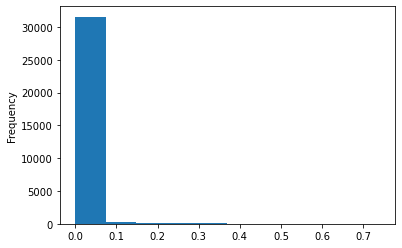

In [175]:
# Average difference between optimised and unoptimised parameters
predictions_1 = model.predict(xtest)
difference = abs(predictions-predictions_1)
print(sum(difference)/len(difference))
print(max(difference)) # Seems like some predictions can vary hugely, try boxplot
pd.Series(difference).plot.hist()

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions_lgbm_01)

In [179]:
feature_df.columns

Index(['n2v_1', 'n2v_2', 'n2v_3', 'n2v_4', 'n2v_5', 'n2v_6', 'n2v_7', 'n2v_8',
       'n2v_9', 'n2v_10',
       ...
       'LHN_index', 'jaccard', 'resource_alloc_ind', 'adamic_adar_ind', 'LRA',
       'dLRA', 'mLRA', 'LRA_approx', 'dLRA_approx', 'mLRA_approx'],
      dtype='object', length=133)